In [1]:
# ==== SETUP: imports, simulador, parámetros y helpers ====
import numpy as np
import csv
import matplotlib.pyplot as plt

# 1) Simulador: usa la versión "fixed" si existe (posición no envuelta + sigmoide estable)
#try:
import simulate_soft_lorentz_diffusion_fixed as sim

# 2) Suma de potencial en la red: más vecinos => fuerza más convergida
try:
    sim.LP = sim.lattice_points(3)   # prueba 4 si quieres aún más robustez
except Exception:
    pass

# 3) Parámetros globales
N             = 600     # partículas por energía
sample_stride = 20      # muestreo de la MSD cada 'sample_stride' pasos
frac_window   = 0.60    # fracción final (cola) usada para el fit lineal de la MSD
R             = 1       # réplicas por energía (usa 3–5 si quieres media±std)

# Alta energía (Fig. 2)
energies_high  = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0]            # puedes añadir 8.0, 10.0
steps_map_high = {2.0:  100000, 3.0: 100000, 4.0: 100000, 5.0: 100000, 6.0: 100000, 7.0: 100000}
dt_map_high    = {2.0: 1e-3,   3.0: 1e-3,   4.0: 1e-3,   5.0: 1e-3,    6.0: 1e-3,    7.0: 1e-3}  # si agregas 8/10 usa 5e-4

# Vecindad E -> 1^+ (Fig. 1b)
energies_near1 = [1.02, 1.03, 1.05, 1.07, 1.10, 1.20]
steps_near1    = 100000
dt_near1       = 1e-3

# 4) Helpers numéricos ---------------------------------------------------------
def fit_tail_MSD(t, msd, frac=0.6):
    """Ajuste lineal de la cola de la MSD: MSD ≈ slope*t + intercept; devuelve D=slope/4."""
    k0 = int(len(t) * (1.0 - frac))
    tk = t[k0:]; yk = msd[k0:]
    A = np.vstack([tk, np.ones_like(tk)]).T
    slope, intercept = np.linalg.lstsq(A, yk, rcond=None)[0]
    yhat = slope*tk + intercept
    resid = yk - yhat
    s_err = np.sqrt(np.mean(resid**2))
    denom = np.sum((tk - np.mean(tk))**2) + 1e-12
    slope_err = s_err / np.sqrt(denom)
    D, D_err = slope/4.0, slope_err/4.0
    return float(D), float(D_err), float(slope), float(intercept), k0

def fit_loglog_weighted(E, D, D_err=None, Emin=2.0):
    """Ajuste y = m x + b en log–log para E>=Emin; ponderado si hay D_err."""
    E, D = np.asarray(E), np.asarray(D)
    mask = (E >= Emin) & np.isfinite(E) & np.isfinite(D) & (D > 0)
    x, y = np.log(E[mask]), np.log(D[mask])

    if D_err is None:
        A = np.vstack([x, np.ones_like(x)]).T
        m, b = np.linalg.lstsq(A, y, rcond=None)[0]
        yhat = m*x + b
        resid = y - yhat
        s_err = np.sqrt(np.mean(resid**2))
        denom = np.sum((x - np.mean(x))**2) + 1e-12
        m_err = s_err / np.sqrt(denom)
        return float(m), float(m_err), float(b), mask

    De = np.asarray(D_err)[mask]
    sigma_y = De / D[mask]
    sigma_y = np.where((~np.isfinite(sigma_y)) | (sigma_y <= 0), np.nan, sigma_y)
    med = np.nanmedian(sigma_y)
    sigma_y = np.where(np.isnan(sigma_y), med, sigma_y)
    w = 1.0 / (sigma_y**2)

    X = np.vstack([x, np.ones_like(x)]).T
    W = np.diag(w)
    cov = np.linalg.inv(X.T @ W @ X)
    beta = cov @ (X.T @ W @ y)
    m, b = float(beta[0]), float(beta[1])
    yhat = m*x + b
    chi2 = np.sum(w * (y - yhat)**2); dof = max(1, len(x) - 2)
    m_err = float(np.sqrt((chi2/dof) * cov[0, 0]))
    return m, m_err, b, mask

def fit_near1(E, D):
    """Ajuste log D vs log(E-1) para E->1^+ (no ponderado por defecto)."""
    E, D = np.asarray(E), np.asarray(D)
    mask = (E > 1.0) & np.isfinite(E) & np.isfinite(D) & (D > 0)
    x, y = np.log(E[mask] - 1.0), np.log(D[mask])
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    yhat = m*x + c
    resid = y - yhat
    s_err = np.sqrt(np.mean(resid**2))
    denom = np.sum((x - np.mean(x))**2) + 1e-12
    m_err = s_err / np.sqrt(denom)
    return float(m), float(m_err), float(c), mask


In [2]:
# ==== COMPUTE: corre todas las energías y guarda resultados ====

rows_high = []        # (E, D_mean, D_err)
MSD_curves = []       # curvas alta energía para plot
for E in energies_high:
    Dt    = dt_map_high.get(E, 1e-3)
    steps = steps_map_high.get(E, 100000)
    Ds = []
    for r in range(R):
        # usa rng si el simulador lo acepta; si no, ignóralo
        try:
            rng = np.random.default_rng(2025 + 31*r)
            t, msd = sim.simulate_msd(E, N=N, dt=Dt, steps=steps,
                                      sample_stride=sample_stride, rng=rng)
        except TypeError:
            t, msd = sim.simulate_msd(E, N=N, dt=Dt, steps=steps,
                                      sample_stride=sample_stride)

        D, D_err, slope, intercept, k0 = fit_tail_MSD(t, msd, frac=frac_window)
        Ds.append(D)
        if r == 0:
            MSD_curves.append((E, t, msd, slope, intercept, k0))

    D_mean = float(np.mean(Ds))
    D_std  = float(np.std(Ds, ddof=1)) if R > 1 else float(D_err)
    rows_high.append((E, D_mean, D_std))

# Guarda CSV alta energía
with open("highE_D_results.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f); w.writerow(["E", "D", "D_err"])
    for E, D, De in rows_high:
        w.writerow([E, D, De])
print("Guardado highE_D_results.csv con", len(rows_high), "puntos.")

# ---- Vecindad E->1+ ----
rows_near = []          # (E, D, D_err)
MSD_curves_near = []    # curvas near-1 para plot
for E in energies_near1:
    try:
        rng = np.random.default_rng(404 + int(100*E))
        t, msd = sim.simulate_msd(E, N=N, dt=dt_near1, steps=steps_near1,
                                  sample_stride=sample_stride, rng=rng)
    except TypeError:
        t, msd = sim.simulate_msd(E, N=N, dt=dt_near1, steps=steps_near1,
                                  sample_stride=sample_stride)

    D, D_err, slope, intercept, k0 = fit_tail_MSD(t, msd, frac=frac_window)
    rows_near.append((E, float(D), float(D_err)))
    MSD_curves_near.append((E, t, msd, slope, intercept, k0))

# Guarda CSV near-1
with open("near1_D_results.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f); w.writerow(["E", "D", "D_err"])
    for E, D, De in rows_near:
        w.writerow([E, D, De])
print("Guardado near1_D_results.csv con", len(rows_near), "puntos.")


C:\Users\Nataly Deluquez\Graficas PAper\simulate_soft_lorentz_diffusion_fixed.py:15: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp((r - r0)/sigma))


Guardado highE_D_results.csv con 6 puntos.
Guardado near1_D_results.csv con 6 puntos.


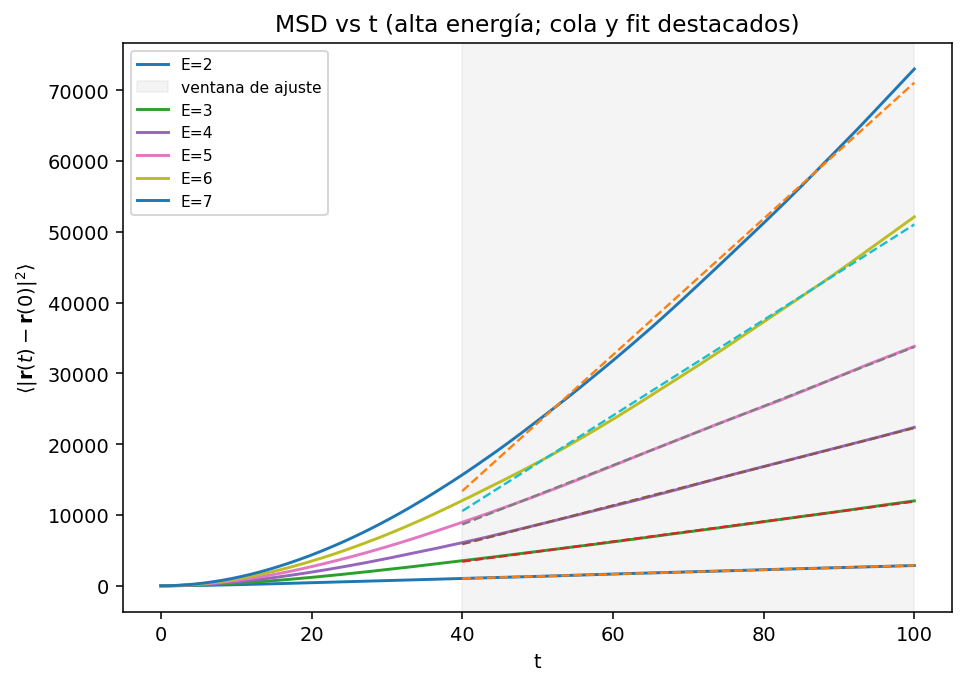

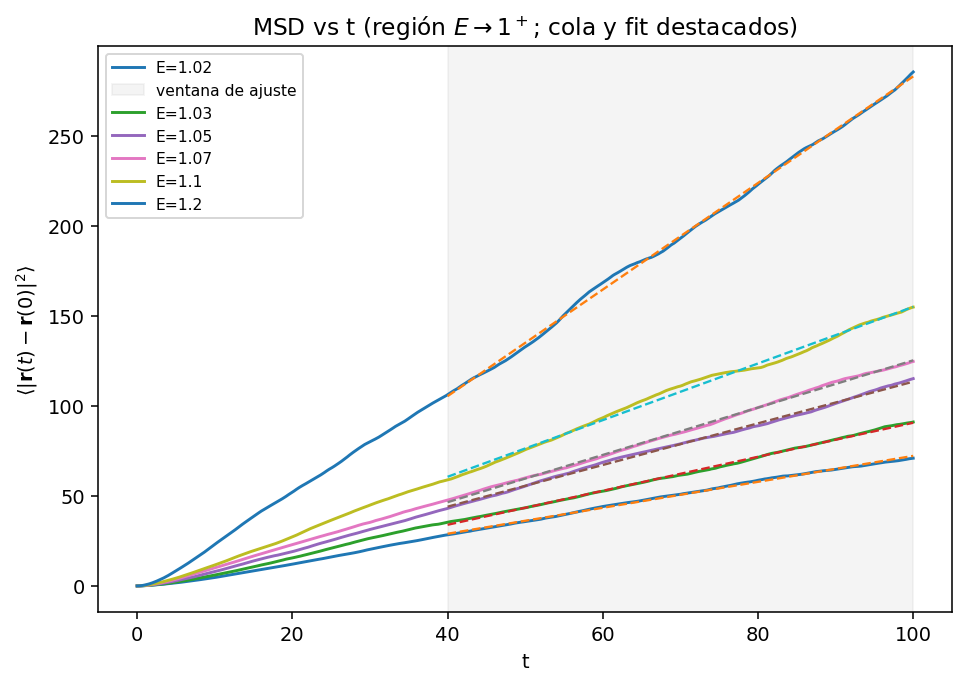

[Alta energía] m = 2.623 ± 0.222 (E≥2)


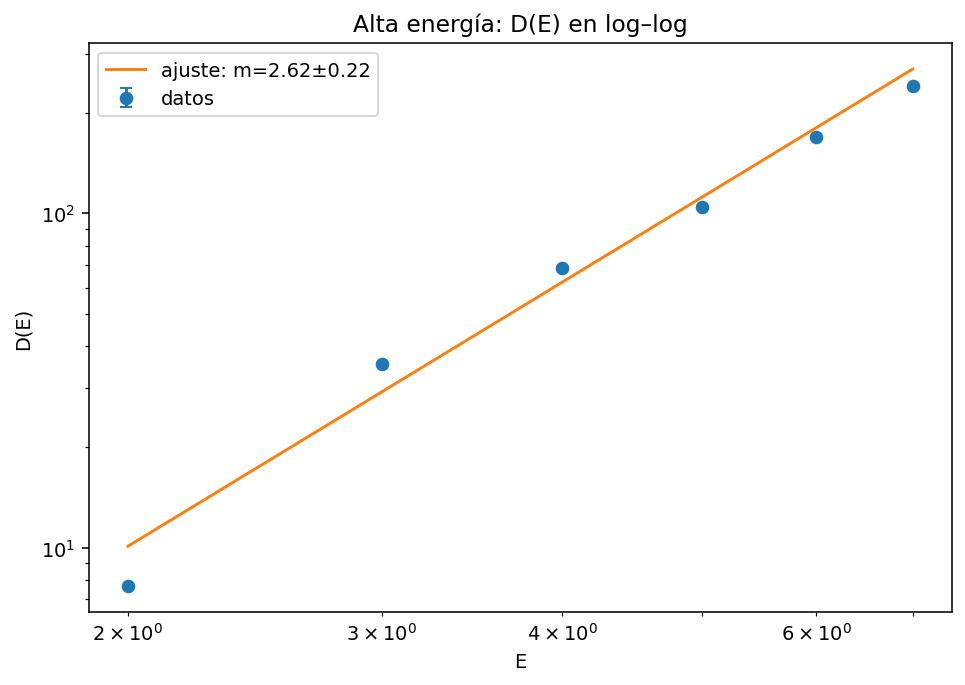

[E→1^+] b = 0.574 ± 0.045


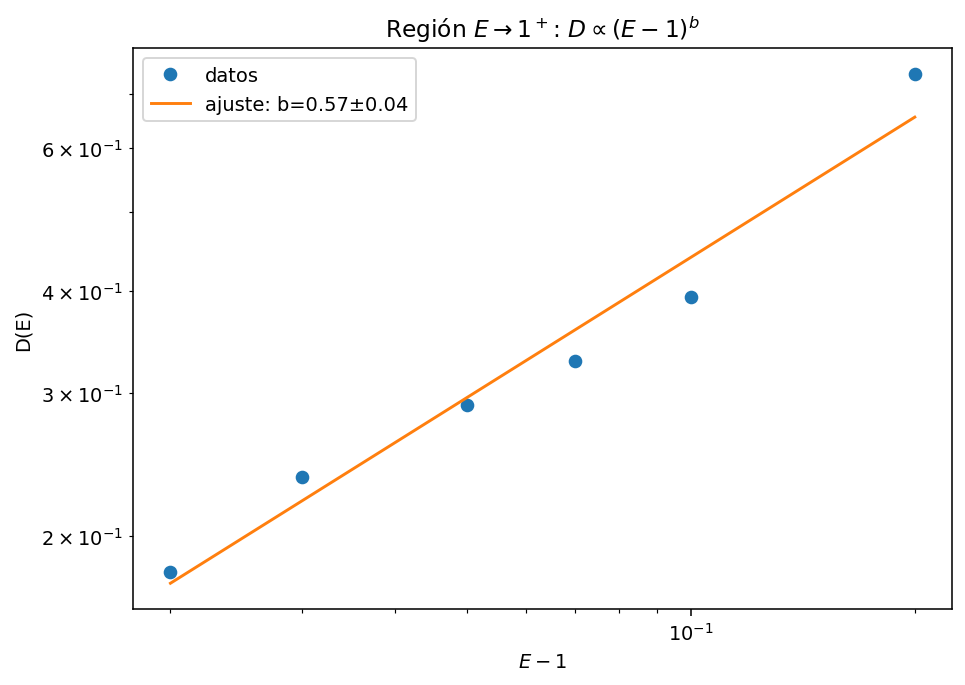

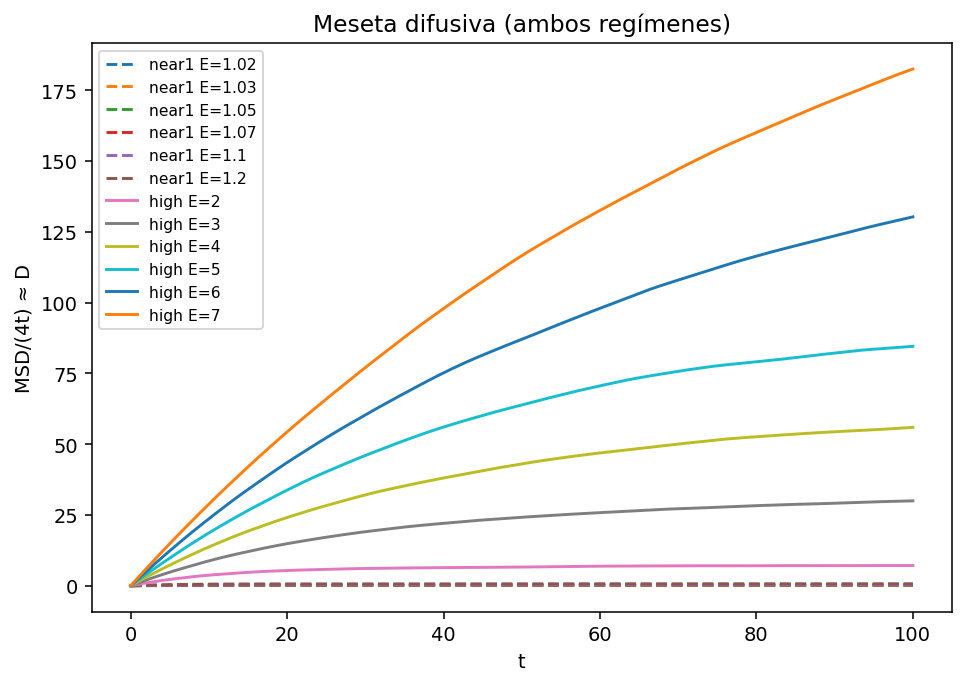

In [3]:
# ==== PLOTS & FITS ====

# 1) MSD vs t (alta energía) con cola sombreada y rectas de ajuste
plt.figure(figsize=(7,5), dpi=140)
first_span = True
for (E, t, msd, slope, intercept, k0) in MSD_curves:
    plt.plot(t, msd, label=f"E={E:g}")
    t_fit = t[k0:]; msd_fit = slope*t_fit + intercept
    plt.plot(t_fit, msd_fit, '--', lw=1.2)
    if first_span:
        plt.axvspan(t[k0], t[-1], color='0.6', alpha=0.10, label='ventana de ajuste')
        first_span = False
plt.xlabel("t"); plt.ylabel(r"$\langle|\mathbf{r}(t)-\mathbf{r}(0)|^2\rangle$")
plt.title("MSD vs t (alta energía; cola y fit destacados)")
plt.legend(fontsize=8); plt.tight_layout()
plt.savefig("MSD_vs_t_alta_energia.png", bbox_inches="tight"); plt.show()

# 2) MSD vs t (E -> 1+) con cola sombreada y rectas de ajuste
plt.figure(figsize=(7,5), dpi=140)
first_span = True
for (E, t, msd, slope, intercept, k0) in MSD_curves_near:
    plt.plot(t, msd, label=f"E={E:g}")
    t_fit = t[k0:]; msd_fit = slope*t_fit + intercept
    plt.plot(t_fit, msd_fit, '--', lw=1.2)
    if first_span:
        plt.axvspan(t[k0], t[-1], color='0.6', alpha=0.10, label='ventana de ajuste')
        first_span = False
plt.xlabel("t"); plt.ylabel(r"$\langle|\mathbf{r}(t)-\mathbf{r}(0)|^2\rangle$")
plt.title(r"MSD vs t (región $E\to 1^+$; cola y fit destacados)")
plt.legend(fontsize=8); plt.tight_layout()
plt.savefig("MSD_vs_t_near1.png", bbox_inches="tight"); plt.show()

# 3) Alta energía: D(E) en log–log + ajuste ponderado si hay barras
E_high  = np.array([r[0] for r in rows_high])
D_high  = np.array([r[1] for r in rows_high])
De_high = np.array([r[2] for r in rows_high])
m, m_err, b, mask = fit_loglog_weighted(E_high, D_high, De_high, Emin=2.0)
print(f"[Alta energía] m = {m:.3f} ± {m_err:.3f} (E≥2)")

plt.figure(figsize=(7,5), dpi=140)
plt.errorbar(E_high, D_high, yerr=De_high, fmt='o', capsize=3, label="datos")
Efit = np.linspace(E_high[mask].min(), E_high[mask].max(), 300)
Dfit = np.exp(m*np.log(Efit) + b)
plt.loglog(Efit, Dfit, '-', label=f"ajuste: m={m:.2f}±{m_err:.2f}")
plt.xlabel("E"); plt.ylabel("D(E)")
plt.title("Alta energía: D(E) en log–log")
plt.legend(); plt.tight_layout()
plt.savefig("DE_loglog_fit_highE.png", bbox_inches="tight"); plt.show()

# 4) Región E -> 1+: D vs (E-1) en log–log + ajuste
E_near = np.array([r[0] for r in rows_near])
D_near = np.array([r[1] for r in rows_near])
bexp, bexp_err, c0, mask2 = fit_near1(E_near, D_near)
print(f"[E→1^+] b = {bexp:.3f} ± {bexp_err:.3f}")

plt.figure(figsize=(7,5), dpi=140)
plt.loglog(E_near-1.0, D_near, 'o', label="datos")
xx = np.linspace((E_near-1.0)[mask2].min(), (E_near-1.0)[mask2].max(), 300)
yy = np.exp(bexp*np.log(xx) + c0)
plt.loglog(xx, yy, '-', label=f"ajuste: b={bexp:.2f}±{bexp_err:.2f}")
plt.xlabel(r"$E-1$"); plt.ylabel("D(E)")
plt.title(r"Región $E\to 1^+$: $D \propto (E-1)^b$")
plt.legend(); plt.tight_layout()
plt.savefig("DE_near1_fit.png", bbox_inches="tight"); plt.show()

# 5) (Opcional) Verificación de meseta difusiva: MSD/(4t)
plt.figure(figsize=(7,5), dpi=140)
for (E, t, msd, *_ ) in MSD_curves_near:
    plt.plot(t, msd/(4.0*np.maximum(t, t[1])), '--', label=f"near1 E={E:g}")
for (E, t, msd, *_ ) in MSD_curves:
    plt.plot(t, msd/(4.0*np.maximum(t, t[1])), label=f"high E={E:g}")
plt.xlabel("t"); plt.ylabel("MSD/(4t) ≈ D")
plt.title("Meseta difusiva (ambos regímenes)")
plt.legend(fontsize=8); plt.tight_layout()
plt.savefig("MSD_over_4t_both.png", bbox_inches="tight"); plt.show()


In [5]:
# ==== TABLAS LaTeX desde CSV (opcional) ====
def load_DE_csv(path):
    E, D, De = [], [], []
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for r in reader:
            E.append(float(r["E"]))
            D.append(float(r["D"]))
            De.append(float(r.get("D_err", "nan")))
    return np.array(E), np.array(D), np.array(De)

def make_table(E, D, De, caption, label):
    rows = []
    for i in range(len(E)):
        if np.isfinite(E[i]) and np.isfinite(D[i]):
            if i < len(De) and np.isfinite(De[i]) and De[i] > 0:
                rows.append(f"{E[i]:.3g} & ${D[i]:.3g} \\pm {De[i]:.2g}$ \\\\")
            else:
                rows.append(f"{E[i]:.3g} & {D[i]:.3g} \\\\")
    body = "\n".join(rows)
    tex = (
        "\\begin{table}[h]\n\\centering\n"
        "\\begin{tabular}{cc}\\hline\n"
        "E & $D(E)$ \\\\\n\\hline\n" + body + "\n\\hline\n"
        "\\end{tabular}\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        "\\end{table}\n"
    )
    return tex

Eh, Dh, Deh = load_DE_csv("highE_D_results.csv")
En, Dn, Den = load_DE_csv("near1_D_results.csv")

tab_near = make_table(En, Dn, Den, "Vecindad de $E\\to1^+$: $D(E)$ usado en el ajuste.", "tab:near1")
tab_high = make_table(Eh, Dh, Deh, "Alta energía ($E\\ge2$): $D(E)$ usado en el ajuste.", "tab:highE")

with open("tablas_resultados_lorentz.tex", "w", encoding="utf-8") as f:
    f.write("\\section*{Tablas de resultados}\n\n" + tab_near + "\n" + tab_high)

print("Generado tablas_resultados_lorentz.tex (incluye Tab.~\\ref{tab:near1} y Tab.~\\ref{tab:highE}).")


Generado tablas_resultados_lorentz.tex (incluye Tab.~\ref{tab:near1} y Tab.~\ref{tab:highE}).
